## *Re-do* of Initial test runs - basic simulations, sparse fields where PSFs are known perfectly.

Original runs were in `26. algorithm shootout - detection-Copy2.ipynb`. These are re-run with more static sources, more variable sources, and accurate ~5-sigma transients.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 16
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

#import time
#time.sleep(600)

3


In [4]:
import diffimTests as dit
reload(dit)

sky = 300.
n_sources = 500
n_varSources = 50
varSourceFlux = 750.

global_psf1 = [1.6,1.6]   # old parameters
global_psf2 = [1.8,2.2]

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=global_psf1, psf2=global_psf2,
                         offset=[0,0], psf_yvary_factor=0., sourceFluxDistrib='exponential',
                         varFlux2=np.repeat(varSourceFlux, n_varSources), variablesNearCenter=False,
                         theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                         sourceFluxRange=(400,100000), scintillation=0.,
                         seed=66, psfSize=21, avoidBorder=True)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

diffimTests.py:265: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  (offset2[0]-starSize+1):(offset2[0]+starSize)] += tmp1
diffimTests.py:290: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  (offset2[0]-starSize+1):(offset2[0]+starSize)] += tmp


(0.93554527333762694, 17.566405874019967, -71.0, 1509.8670984857436)
(1.2861313967106818, 17.65627031518687, -71.0, 1022.5230042609983)
(300.93554527333754, 17.566405874019967, 229.0, 1809.8670984857436)
(301.28613139671069, 17.65627031518687, 229.0, 1322.5230042609983)


In [6]:
det = testObj.runTest()
print det

{'ZOGY': {'FP': 3, 'FN': 31, 'TP': 18}, 'ALstack': {'FP': 6, 'FN': 35, 'TP': 14}, 'SZOGY': {'FP': 6, 'FN': 39, 'TP': 10}, 'ALstack_noDecorr': {'FP': 5, 'FN': 31, 'TP': 18}}


Try some real tests!

In [9]:
# Default 10 sources with same flux
def runTest(flux, seed=66, sky=300., n_sources=500, n_varSources=50):
    #methods = ['ALstack', 'ZOGY', 'ZOGY_S', 'ALstack_noDecorr']
    testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=global_psf1, psf2=global_psf2,
                             offset=[0,0], psf_yvary_factor=0., sourceFluxDistrib='exponential',
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(400,100000), scintillation=0.,
                             seed=seed, psfSize=21, avoidBorder=True)
    det = testObj.runTest() #subtractMethods=methods) #, 'AL'])
    det['flux'] = flux
    return det

methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

## Look at detection rates for 5.0-sigma sources.

In [10]:
inputs = [(f, seed) for f in [750.] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=500, n_varSources=50) \
                                                     for i in inputs)

100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  7.8min finished


FN: 
ALstack             36.22
ALstack_noDecorr    34.67
SZOGY               36.68
ZOGY                34.07
dtype: float64
FP: 
ALstack             4.79
ALstack_noDecorr    5.64
SZOGY               5.57
ZOGY                4.31
dtype: float64
TP: 
ALstack             13.72
ALstack_noDecorr    15.26
SZOGY               13.24
ZOGY                15.86
dtype: float64


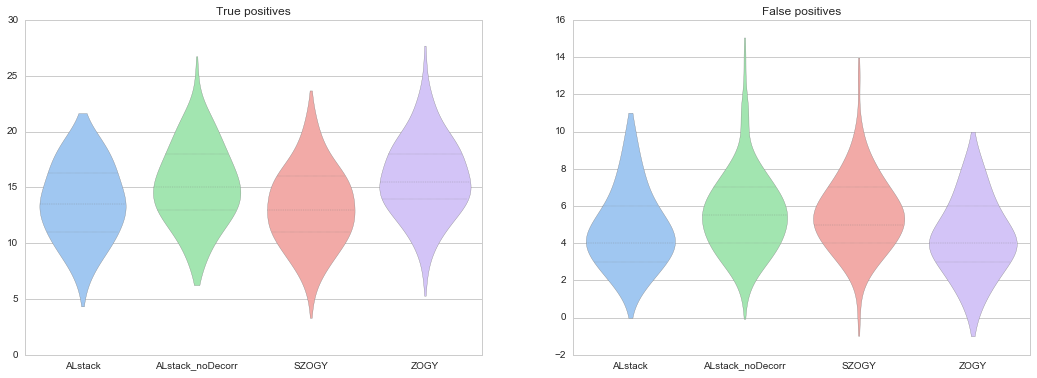

In [20]:
def plotResults(tr):
    FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
    TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
    print 'FN:', '\n', FN.mean()
    print 'FP:', '\n', FP.mean()
    print 'TP:', '\n', TP.mean()

    matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
    axes[0].set_title('True positives')
    #axes[0].set_ylim((0, 31))
    sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
    axes[1].set_title('False positives')
    #axes[1].set_ylim((-1, 15))
    
plotResults(testResults1)

## Look at detection rates for 3.33-sigma sources.

In [23]:
inputs = [(f, seed) for f in [500.] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=500, n_varSources=50) \
                                                     for i in inputs)

100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  7.3min finished


FN: 
ALstack             48.60
ALstack_noDecorr    48.26
SZOGY               48.62
ZOGY                48.17
dtype: float64
FP: 
ALstack             2.06
ALstack_noDecorr    2.40
SZOGY               1.02
ZOGY                0.97
dtype: float64
TP: 
ALstack             1.35
ALstack_noDecorr    1.68
SZOGY               1.34
ZOGY                1.76
dtype: float64


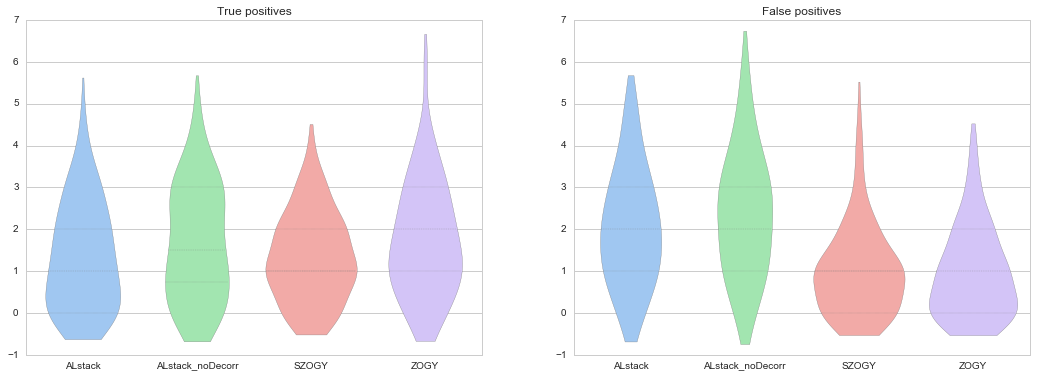

In [25]:
plotResults(testResults2)

## For fun, try some 10-sigma sources.

In [16]:
inputs = [(f, seed) for f in [1500.] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults3 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=500, n_varSources=50) \
                                                     for i in inputs)

100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.7min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  7.7min finished


FN: 
ALstack             9.87
ALstack_noDecorr    6.54
SZOGY               8.38
ZOGY                6.30
dtype: float64
FP: 
ALstack             2.83
ALstack_noDecorr    3.04
SZOGY               3.88
ZOGY                1.84
dtype: float64
TP: 
ALstack             40.06
ALstack_noDecorr    43.39
SZOGY               41.54
ZOGY                43.62
dtype: float64


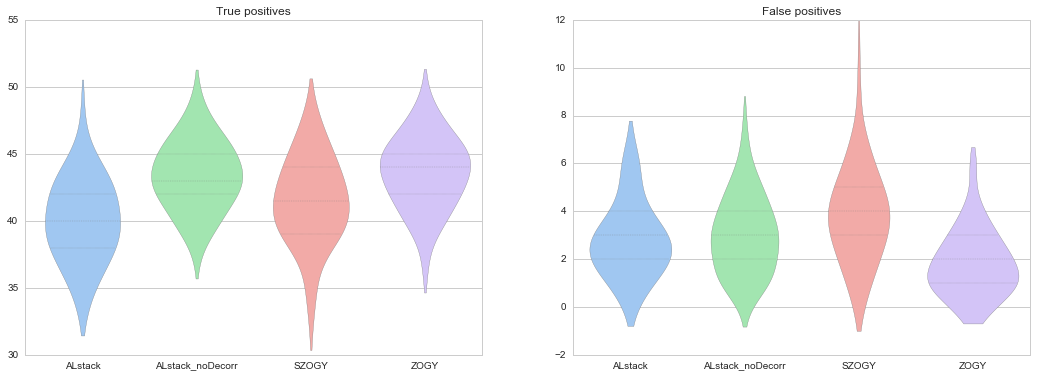

In [21]:
plotResults(testResults3)

In [26]:
import cPickle
import gzip
cPickle.dump((testResults1, testResults2, testResults3), gzip.GzipFile('testResults_NEW.p.gz', 'wb'))